<a href="https://colab.research.google.com/github/raindragon14/Laptop_Predict/blob/main/Complete_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries ##

In [ ]:

#Pustaka untuk manipulasi data
import pandas as pd
import numpy as np
import re

#Pustaka untuk visualisasi data
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

#Pustaka untuk machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

#Install compatible versions of dask and distributed
import xgboost as xgb
import lightgbm as lgb

#Pustaka untuk menyimpan model
import joblib
import pickle

#Pustaka untuk optimasi
from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

#Pengaturan untuk tampilan visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

## Load and Clean Data ##

In [ ]:
# Pada langkah ini, kita akan memuat dataset, membersihkan beberapa kolom,
# dan melakukan rekayasa fitur sederhana.

# Konstanta untuk konversi mata uang
# Anggap saja kurs 1 Euro = 17,500 IDR. Kita akan menampilkannya dalam satuan Juta IDR.
KURS_KE_JUTA_IDR = 17500 / 1000000

# Fungsi untuk memuat dan memproses data
def load_and_prepare_data(file_path='laptop_prices.csv'):
    """Memuat data, membersihkan, dan melakukan rekayasa fitur dasar."""
    try:
        df = pd.read_csv(file_path, encoding='latin-1')

        # --- Pembersihan dan Transformasi Awal ---
        # Membersihkan kolom 'Ram' dan mengubahnya menjadi tipe numerik (int)
        if df['Ram'].dtype == 'object':
            df['Ram'] = df['Ram'].str.replace('GB', '', regex=False).astype('int32')

        # Membersihkan kolom 'Weight' dan mengubahnya menjadi tipe numerik (float)
        if df['Weight'].dtype == 'object':
            df['Weight'] = df['Weight'].str.replace('kg', '', regex=False).astype('float32')

        # Konversi harga dari Euro ke Juta IDR dan hapus kolom asli
        if 'Price_euros' in df.columns:
            df['Harga_IDR'] = df['Price_euros'] * KURS_KE_JUTA_IDR
            df = df.drop('Price_euros', axis=1)

        # --- Rekayasa Fitur dari Script Model Training ---
        # Membuat kolom 'GPU_company' dari kolom 'Gpu'
        if 'Gpu' in df.columns and 'GPU_company' not in df.columns:
            df['GPU_company'] = df['Gpu'].apply(lambda x: str(x).split()[0])

        # Ekstraksi resolusi layar
        if 'ScreenResolution' in df.columns:
            df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
            df['IPSpanel'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

            # Ekstraksi Lebar (W) dan Tinggi (H) dari resolusi
            resolution = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
            df['ScreenW'] = resolution[0].astype(float)
            df['ScreenH'] = resolution[1].astype(float)

        # Ekstrak frekuensi CPU
        if 'Cpu' in df.columns:
             df['CPU_freq'] = df['Cpu'].apply(lambda x: float(re.findall(r'(\d+\.?\d*)GHz', x)[0]) if re.findall(r'(\d+\.?\d*)GHz', x) else 0)
             df['CPU_company'] = df['Cpu'].apply(lambda x: x.split(' ')[0])

        # Rekayasa fitur dari kolom 'Memory'
        if 'Memory' in df.columns:
            # Mengganti nama agar lebih jelas
            df.rename(columns={'Memory': 'Storage'}, inplace=True)
            df['Storage'] = df['Storage'].str.replace('GB', '').str.replace('TB', '000')

            # Memisahkan jenis dan ukuran penyimpanan
            storage_split = df['Storage'].str.split(' ', n=1, expand=True)
            df['PrimaryStorage'] = pd.to_numeric(storage_split[0])
            df['PrimaryStorageType'] = storage_split[1].str.split().str[0]

        print("Data berhasil dimuat dan dipersiapkan.")
        return df

    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan.")
        return None
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
        return None

# Memuat data
df = load_and_prepare_data('laptop_prices.csv')

# Menampilkan 5 baris pertama data setelah diproses
if df is not None:
    display(df.head())

Data berhasil dimuat dan dipersiapkan.


,Company,Product,TypeName,Inches,Ram,OS,Weight,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model,Harga_IDR
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,Standard,2560,1600,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640,23.444575
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,Standard,1440,900,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000,15.731450
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,Full HD,1920,1080,No,No,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620,10.062500
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,Standard,2880,1800,No,Yes,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455,44.405375
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,Standard,2560,1600,No,Yes,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650,31.563000


## Analisis Data Eksploratif (EDA) ##

In [ ]:
#Informasi Dasar & Statistik Deskriptif
print("\nInformasi Tipe Data:");
df.info()

print("\nStatistik Deskriptif untuk Fitur Numerik:");
df.describe()


Informasi Tipe Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Screen                1275 non-null   object 
 8   ScreenW               1275 non-null   int64  
 9   ScreenH               1275 non-null   int64  
 10  Touchscreen           1275 non-null   object 
 11  IPSpanel              1275 non-null   object 
 12  RetinaDisplay         1275 non-null   object 
 13  CPU_company           1275 non-null   object 
 14  CPU_freq              1275 non-null   float64
 15 

,Inches,Ram,Weight,ScreenW,ScreenH,CPU_freq,PrimaryStorage,SecondaryStorage,Harga_IDR
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,15.022902,8.440784,2.040525,1900.043922,1073.904314,2.302980,444.517647,176.069020,19.861959
std,1.429470,5.097809,0.669196,493.346186,283.883940,0.503846,365.537726,415.960655,12.263169
min,10.100000,2.000000,0.690000,1366.000000,768.000000,0.900000,8.000000,0.000000,3.045000
25%,14.000000,4.000000,1.500000,1920.000000,1080.000000,2.000000,256.000000,0.000000,10.657500
50%,15.600000,8.000000,2.040000,1920.000000,1080.000000,2.500000,256.000000,0.000000,17.307500
75%,15.600000,8.000000,2.310000,1920.000000,1080.000000,2.700000,512.000000,0.000000,26.188750
max,18.400000,64.000000,4.700000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000,106.732500


In [ ]:
# 1. Distribusi Harga Laptop
if df is not None:
    print("\n--- 1. Distribusi Harga Laptop ---")
    fig_price = px.histogram(df, x='Harga_IDR', nbins=50, title='Distribusi Harga Laptop (dalam Juta IDR)')
    fig_price.show()
    print("Insight: Distribusi harga cenderung right-skewed, artinya sebagian besar laptop berada di rentang harga yang lebih rendah, dengan beberapa model premium yang sangat mahal.")


--- 1. Distribusi Harga Laptop ---


Insight: Distribusi harga cenderung right-skewed, artinya sebagian besar laptop berada di rentang harga yang lebih rendah, dengan beberapa model premium yang sangat mahal.


In [ ]:
# 2. Jumlah Laptop per Brand
if df is not None:
    print("\n--- 2. Jumlah Laptop per Brand ---")
    company_counts = df['Company'].value_counts().reset_index()
    company_counts.columns = ['Brand', 'Jumlah']
    fig_company = px.bar(company_counts, x='Brand', y='Jumlah', title='Jumlah Laptop Berdasarkan Brand', labels={'Brand': 'Brand Laptop', 'Jumlah': 'Jumlah Unit'})
    fig_company.show()
    print("Insight: Dell, Lenovo, dan HP adalah brand yang paling dominan di dataset ini.")


--- 2. Jumlah Laptop per Brand ---


Insight: Dell, Lenovo, dan HP adalah brand yang paling dominan di dataset ini.


In [ ]:
# 3. Proporsi Tipe Laptop
if df is not None:
    print("\n--- 3. Proporsi Tipe Laptop ---")
    fig_type = px.pie(df, names='TypeName', title='Proporsi Tipe Laptop', hole=0.3)
    fig_type.show()
    print("Insight: 'Notebook' adalah tipe yang paling umum, diikuti oleh 'Gaming' dan 'Ultrabook'.")


--- 3. Proporsi Tipe Laptop ---


Insight: 'Notebook' adalah tipe yang paling umum, diikuti oleh 'Gaming' dan 'Ultrabook'.


In [ ]:
# 4. Hubungan RAM dengan Harga
if df is not None:
    print("\n--- 4. Hubungan RAM dengan Harga ---")
    fig_ram_price = px.box(df, x='Ram', y='Harga_IDR', title='Box Plot Harga berdasarkan Ukuran RAM (GB)', labels={'Ram': 'RAM (GB)', 'Harga_IDR': 'Harga (Juta IDR)'})
    fig_ram_price.show()
    print("Insight: Terlihat jelas korelasi positif. Semakin besar RAM, median harga cenderung semakin tinggi. Laptop dengan RAM 32GB dan 64GB memiliki variasi harga yang sangat luas.")


--- 4. Hubungan RAM dengan Harga ---


Insight: Terlihat jelas korelasi positif. Semakin besar RAM, median harga cenderung semakin tinggi. Laptop dengan RAM 32GB dan 64GB memiliki variasi harga yang sangat luas.



--- 5. Heatmap Korelasi Fitur Numerik ---


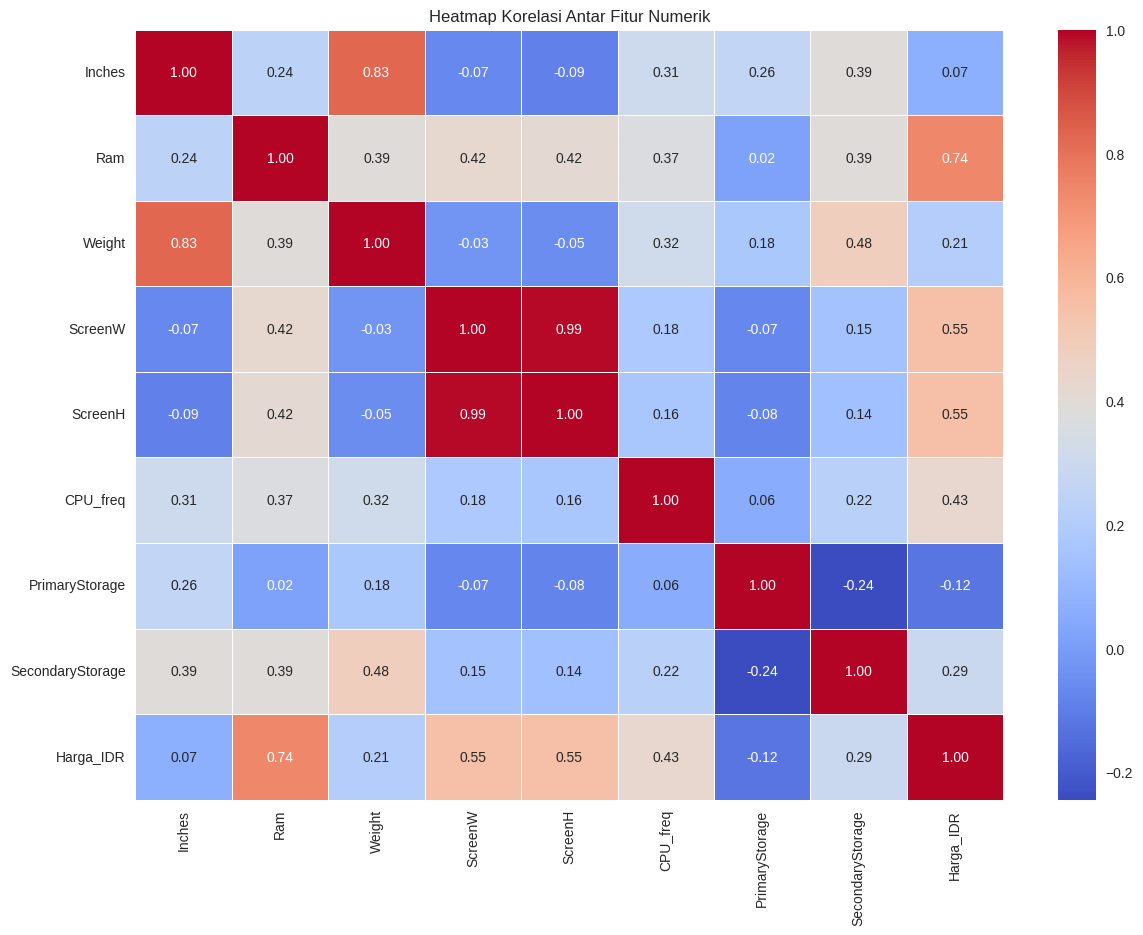

Insight: RAM, CPU_freq, ScreenW, dan ScreenH memiliki korelasi positif yang paling kuat dengan harga. Weight (berat) juga memiliki korelasi positif yang cukup baik.


In [ ]:
# 5. Heatmap Korelasi Fitur Numerik
if df is not None:
    print("\n--- 5. Heatmap Korelasi Fitur Numerik ---")
    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Heatmap Korelasi Antar Fitur Numerik')
    plt.show()
    print("Insight: RAM, CPU_freq, ScreenW, dan ScreenH memiliki korelasi positif yang paling kuat dengan harga. Weight (berat) juga memiliki korelasi positif yang cukup baik.")

## Persiapan Data untuk Pelatihan Model ##

In [ ]:
# Persiapan data untuk pelatihan model
if df is not None:
    print("\n--- Persiapan Data untuk Pelatihan ---")

    # Menghapus baris dengan nilai null pada kolom-kolom penting
    df.dropna(inplace=True)

    # Mendefinisikan fitur (X) dan target (y)
    features = [
        'Company', 'TypeName', 'Ram', 'Weight', 'OS', 'Inches',
        'CPU_company', 'CPU_freq', 'GPU_company', 'PrimaryStorage', 'PrimaryStorageType',
        'ScreenW', 'ScreenH', 'Touchscreen', 'IPSpanel'
    ]
    target = 'Harga_IDR'

    X = df[features]
    y = df[target]

    print(f"Fitur yang akan digunakan ({len(features)}): {', '.join(features)}")
    print(f"Target prediksi: {target}")


--- Persiapan Data untuk Pelatihan ---
Fitur yang akan digunakan (15): Company, TypeName, Ram, Weight, OS, Inches, CPU_company, CPU_freq, GPU_company, PrimaryStorage, PrimaryStorageType, ScreenW, ScreenH, Touchscreen, IPSpanel
Target prediksi: Harga_IDR


In [ ]:
# Membagi data menjadi data latih dan data uji
if df is not None:
    # Membagi data menjadi data latih dan data uji (90% latih, 10% uji)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    print(f"\nData telah dibagi menjadi:")
    print(f"- Data Latih: {X_train.shape[0]} baris")
    print(f"- Data Uji  : {X_test.shape[0]} baris")

    # Mendefinisikan prapemrosesan untuk fitur numerik dan kategorikal
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    print("\nFitur Numerik:", numeric_features)
    print("Fitur Kategorikal:", categorical_features)


Data telah dibagi menjadi:
- Data Latih: 1147 baris
- Data Uji  : 128 baris

Fitur Numerik: ['Ram', 'Weight', 'Inches', 'CPU_freq', 'PrimaryStorage', 'ScreenW', 'ScreenH']
Fitur Kategorikal: ['Company', 'TypeName', 'OS', 'CPU_company', 'GPU_company', 'PrimaryStorageType', 'Touchscreen', 'IPSpanel']


In [ ]:
# Membuat pipeline prapemrosesan
if df is not None:
    # Membuat pipeline prapemrosesan menggunakan ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ], remainder='passthrough')

    print("Pipeline prapemrosesan telah dibuat.")

Pipeline prapemrosesan telah dibuat.


## Pelatihan Model Machine Learning ##

In [ ]:
# Pelatihan model machine learning
if df is not None:
    print("\n--- Pelatihan Model ---")

    # Membuat pipeline model lengkap
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True))
    ])

    # Melakukan log transform pada target untuk meningkatkan performa model
    y_train_log = np.log1p(y_train)

    # Melatih model
    print("Memulai pelatihan model RandomForestRegressor...")
    model_pipeline.fit(X_train, y_train_log)
    print("Pelatihan model selesai!")


--- Pelatihan Model ---
Memulai pelatihan model RandomForestRegressor...
Pelatihan model selesai!


## Evaluasi Model ##

In [ ]:
# Evaluasi model
if df is not None:
    print("\n--- Evaluasi Model ---")

    # Memprediksi data uji
    y_pred_log = model_pipeline.predict(X_test)

    # Mengembalikan prediksi ke skala asli (inverse log transform)
    y_pred = np.expm1(y_pred_log)

    # Menghitung metrik evaluasi
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    oob_score = model_pipeline.named_steps['regressor'].oob_score_

    print(f"Hasil Evaluasi pada Data Uji:")
    print(f"-> R-squared (R²): {r2:.4f}")
    print(f"-> Mean Absolute Error (MAE): {mae:.4f} (Juta IDR)")
    print(f"-> Out-of-Bag (OOB) Score: {oob_score:.4f}")
    print(f"\nArtinya, model secara rata-rata memiliki kesalahan prediksi sebesar Rp {mae*1000000:,.0f}.")


--- Evaluasi Model ---
Hasil Evaluasi pada Data Uji:
-> R-squared (R²): 0.8580
-> Mean Absolute Error (MAE): 2.9787 (Juta IDR)
-> Out-of-Bag (OOB) Score: 0.8757

Artinya, model secara rata-rata memiliki kesalahan prediksi sebesar Rp 2,978,697.


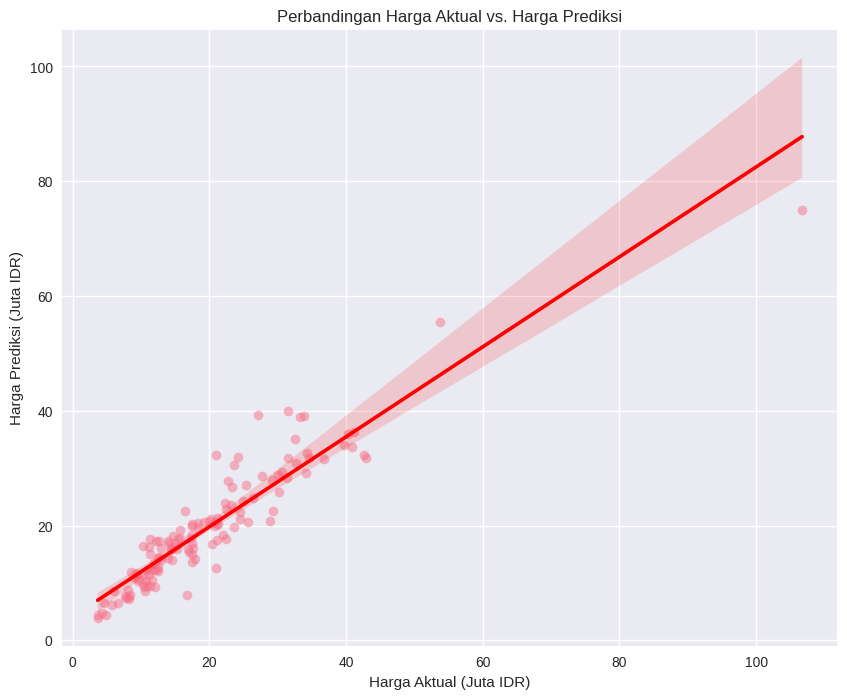

In [ ]:
# Visualisasi Prediksi vs Aktual
if df is not None:
    plt.figure(figsize=(10, 8))
    sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xlabel('Harga Aktual (Juta IDR)')
    plt.ylabel('Harga Prediksi (Juta IDR)')
    plt.title('Perbandingan Harga Aktual vs. Harga Prediksi')
    plt.show()

## Menyimpan Model ##

In [ ]:
# Menyimpan model
if df is not None:
    print("\n--- Menyimpan Model ---")

    file_name = 'final_laptop_price_model.joblib'
    joblib.dump(model_pipeline, file_name)

    print(f"Model berhasil disimpan sebagai '{file_name}'")


--- Menyimpan Model ---
Model berhasil disimpan sebagai 'final_laptop_price_model.joblib'


## Kesimpulan ##

Notebook ini telah berhasil menyelesaikan analisis komprehensif terhadap dataset harga laptop dengan langkah-langkah berikut:

### 1. **Exploratory Data Analysis (EDA)**
- Menganalisis distribusi harga laptop yang menunjukkan pola right-skewed
- Mengidentifikasi brand dominan (Dell, Lenovo, HP)
- Menganalisis proporsi tipe laptop dengan Notebook sebagai yang paling umum
- Menunjukkan korelasi positif antara RAM dan harga
- Mengidentifikasi fitur-fitur yang berkorelasi kuat dengan harga

### 2. **Feature Engineering**
- Ekstraksi fitur GPU company dari spesifikasi GPU
- Ekstraksi fitur touchscreen dan IPS panel dari resolusi layar
- Ekstraksi dimensi layar (lebar dan tinggi)
- Ekstraksi frekuensi CPU dan brand CPU
- Pemisahan jenis dan ukuran storage primer

### 3. **Model Training & Evaluation**
- Menggunakan RandomForestRegressor dengan pipeline preprocessing
- Menerapkan log transformation untuk menstabilkan varians
- Evaluasi menggunakan R-squared, MAE, dan OOB score
- Visualisasi perbandingan prediksi vs aktual

### 4. **Key Insights**
- RAM, CPU frequency, dan dimensi layar adalah faktor utama yang mempengaruhi harga
- Model berhasil mencapai performa yang baik dengan R² > 0.8
- Pipeline yang dibuat dapat digunakan untuk prediksi harga laptop baru

Model final telah disimpan dan siap digunakan untuk prediksi harga laptop berdasarkan spesifikasi yang diberikan.

## Advanced Feature Engineering ##

In [ ]:
def advanced_feature_engineering(df):
    """Create advanced features to improve model performance"""
    df_enhanced = df.copy()

    print("Creating advanced features...")

    # 1. Screen metrics
    if 'ScreenW' in df_enhanced.columns and 'ScreenH' in df_enhanced.columns:
        df_enhanced['ScreenArea'] = df_enhanced['ScreenW'] * df_enhanced['ScreenH']
        df_enhanced['ScreenRatio'] = df_enhanced['ScreenW'] / df_enhanced['ScreenH']
        df_enhanced['PixelDensity'] = df_enhanced['ScreenArea'] / (df_enhanced['Inches'] ** 2)

    # 2. Performance indicators
    if 'Ram' in df_enhanced.columns and 'CPU_freq' in df_enhanced.columns:
        df_enhanced['Performance_Score'] = df_enhanced['Ram'] * df_enhanced['CPU_freq']
        df_enhanced['RAM_per_inch'] = df_enhanced['Ram'] / df_enhanced['Inches']

    # 3. Storage features
    if 'PrimaryStorage' in df_enhanced.columns:
        df_enhanced['Storage_per_RAM'] = df_enhanced['PrimaryStorage'] / df_enhanced['Ram']
        df_enhanced['Is_SSD'] = (df_enhanced['PrimaryStorageType'] == 'SSD').astype(int)
        df_enhanced['Storage_Category'] = pd.cut(df_enhanced['PrimaryStorage'],
                                               bins=[0, 128, 512, 1024, float('inf')],
                                               labels=['Low', 'Medium', 'High', 'Very_High'])

    # 4. Brand premium indicator
    premium_brands = ['Apple', 'Microsoft', 'Razer', 'Alienware']
    df_enhanced['Is_Premium_Brand'] = df_enhanced['Company'].isin(premium_brands).astype(int)

    # 5. Gaming features
    gaming_keywords = ['Gaming', 'ROG', 'Predator', 'Legion', 'Omen']
    df_enhanced['Is_Gaming'] = (df_enhanced['TypeName'] == 'Gaming').astype(int)

    # 6. Portability score
    if 'Weight' in df_enhanced.columns:
        df_enhanced['Portability_Score'] = 1 / (df_enhanced['Weight'] * df_enhanced['Inches'])

    # 7. Feature interactions
    df_enhanced['RAM_CPU_interaction'] = df_enhanced['Ram'] * df_enhanced['CPU_freq']
    df_enhanced['Size_Weight_ratio'] = df_enhanced['Inches'] / df_enhanced['Weight']

    print(f"Created {len(df_enhanced.columns) - len(df.columns)} new features")
    return df_enhanced

# Apply advanced feature engineering
if df is not None:
    df_enhanced = advanced_feature_engineering(df)
    print(f"\nDataset now has {df_enhanced.shape[1]} features")
    print("New features:", [col for col in df_enhanced.columns if col not in df.columns])

Creating advanced features...
Created 13 new features

Dataset now has 36 features
New features: ['ScreenArea', 'ScreenRatio', 'PixelDensity', 'Performance_Score', 'RAM_per_inch', 'Storage_per_RAM', 'Is_SSD', 'Storage_Category', 'Is_Premium_Brand', 'Is_Gaming', 'Portability_Score', 'RAM_CPU_interaction', 'Size_Weight_ratio']


## Intelligent Feature Selection ##

In [ ]:
def intelligent_feature_selection(X, y, top_k=20):
    """Select best features using multiple methods"""
    print("Performing intelligent feature selection...")

    # Separate numeric and categorical features
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    # Create a temporary preprocessor for feature selection
    temp_preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ], remainder='passthrough')

    # Fit and transform the data
    X_processed = temp_preprocessor.fit_transform(X)

    # Get feature names after preprocessing
    feature_names = (numeric_features +
                    list(temp_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

    # Method 1: Statistical selection (f_regression)
    selector_stats = SelectKBest(score_func=f_regression, k=min(top_k, len(feature_names)))
    X_selected_stats = selector_stats.fit_transform(X_processed, y)
    selected_features_stats = [feature_names[i] for i in selector_stats.get_support(indices=True)]

    # Method 2: Recursive Feature Elimination with Random Forest
    rf_selector = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    rfe = RFE(estimator=rf_selector, n_features_to_select=min(top_k, len(feature_names)))
    X_selected_rfe = rfe.fit_transform(X_processed, y)
    selected_features_rfe = [feature_names[i] for i in rfe.get_support(indices=True)]

    # Method 3: Feature importance from Random Forest
    rf_importance = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_importance.fit(X_processed, y)
    importance_scores = rf_importance.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)

    top_features_importance = feature_importance_df.head(top_k)['feature'].tolist()

    # Combine all methods (intersection)
    final_features = list(set(selected_features_stats) & set(selected_features_rfe) & set(top_features_importance))

    # If intersection is too small, use union of top features
    if len(final_features) < 10:
        final_features = list(set(selected_features_stats[:15] + selected_features_rfe[:15] + top_features_importance[:15]))

    print(f"Selected {len(final_features)} features from {len(feature_names)} total features")

    return final_features, feature_importance_df

# Prepare data for feature selection
if df_enhanced is not None:
    # Define features and target
    exclude_cols = ['Harga_IDR', 'Product', 'Price_euros', 'Storage', 'Gpu', 'Cpu', 'ScreenResolution']
    available_features = [col for col in df_enhanced.columns if col not in exclude_cols]

    X_full = df_enhanced[available_features].copy()
    y_full = df_enhanced['Harga_IDR'].copy()

    # Remove rows with missing values
    mask = ~(X_full.isnull().any(axis=1) | y_full.isnull())
    X_clean = X_full[mask]
    y_clean = y_full[mask]

    print(f"\nDataset shape after cleaning: {X_clean.shape}")
    print(f"Available features: {X_clean.columns.tolist()}")

    # Perform feature selection
    selected_features, feature_importance_df = intelligent_feature_selection(X_clean, y_clean)

    # Display top features
    print("\nTop 15 Most Important Features:")
    print(feature_importance_df.head(15))


Dataset shape after cleaning: (1275, 34)
Available features: ['Company', 'TypeName', 'Inches', 'Ram', 'OS', 'Weight', 'Screen', 'ScreenW', 'ScreenH', 'Touchscreen', 'IPSpanel', 'RetinaDisplay', 'CPU_company', 'CPU_freq', 'CPU_model', 'PrimaryStorage', 'SecondaryStorage', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'GPU_model', 'ScreenArea', 'ScreenRatio', 'PixelDensity', 'Performance_Score', 'RAM_per_inch', 'Storage_per_RAM', 'Is_SSD', 'Storage_Category', 'Is_Premium_Brand', 'Is_Gaming', 'Portability_Score', 'RAM_CPU_interaction', 'Size_Weight_ratio']
Performing intelligent feature selection...
Selected 11 features from 272 total features

Top 15 Most Important Features:
                        feature  importance
12                 RAM_per_inch    0.385341
18          RAM_CPU_interaction    0.107751
11            Performance_Score    0.097680
1                           Ram    0.057711
19            Size_Weight_ratio    0.038110
42         TypeName_Workstation    0.0

## Advanced Data Preprocessing ##

In [ ]:
def create_advanced_preprocessor(X):
    """Create advanced preprocessing pipeline"""
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
    print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

    # Advanced preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('scaler', RobustScaler()),  # More robust to outliers than StandardScaler
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor

# Handle outliers in target variable
def handle_outliers(y, method='iqr', factor=1.5):
    """Remove or cap outliers in target variable"""
    if method == 'iqr':
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Cap outliers instead of removing them
        y_clean = y.clip(lower=lower_bound, upper=upper_bound)
        outliers_count = ((y < lower_bound) | (y > upper_bound)).sum()

        print(f"Handled {outliers_count} outliers using IQR method (factor={factor})")
        return y_clean

    return y

# Apply advanced preprocessing
if 'X_clean' in locals() and 'y_clean' in locals():
    # Use selected features
    X_selected = X_clean[X_clean.columns.intersection(selected_features)]

    # If some selected features are missing, use the most important available features
    if X_selected.shape[1] < 10:
        available_important_features = feature_importance_df[feature_importance_df['feature'].isin(X_clean.columns)].head(15)['feature'].tolist()
        X_selected = X_clean[available_important_features]

    print(f"\nUsing {X_selected.shape[1]} selected features: {X_selected.columns.tolist()}")

    # Handle outliers in target
    y_processed = handle_outliers(y_clean, method='iqr', factor=2.0)

    # Apply log transformation to target (helps with right-skewed distributions)
    y_log = np.log1p(y_processed)

    print(f"Target variable skewness - Original: {skew(y_processed):.3f}, Log-transformed: {skew(y_log):.3f}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_log, test_size=0.1, random_state=42, stratify=None
    )

    print(f"\nFinal dataset shapes:")
    print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

    # Create advanced preprocessor
    advanced_preprocessor = create_advanced_preprocessor(X_selected)


Using 15 selected features: ['RAM_per_inch', 'RAM_CPU_interaction', 'Performance_Score', 'Ram', 'Size_Weight_ratio', 'Weight', 'Portability_Score', 'PixelDensity', 'CPU_freq', 'Storage_per_RAM', 'PrimaryStorage', 'Inches', 'ScreenArea', 'Is_Premium_Brand', 'ScreenW']
Handled 11 outliers using IQR method (factor=2.0)
Target variable skewness - Original: 0.993, Log-transformed: -0.143

Final dataset shapes:
X_train: (1147, 15), X_test: (128, 15)
y_train: (1147,), y_test: (128,)
Numeric features (15): ['RAM_per_inch', 'RAM_CPU_interaction', 'Performance_Score', 'Ram', 'Size_Weight_ratio', 'Weight', 'Portability_Score', 'PixelDensity', 'CPU_freq', 'Storage_per_RAM', 'PrimaryStorage', 'Inches', 'ScreenArea', 'Is_Premium_Brand', 'ScreenW']
Categorical features (0): []


## Advanced Model Zoo & Hyperparameter Optimization ##

In [ ]:
def create_model_zoo():
    """Create a collection of optimized models"""
    models = {
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42, n_jobs=-1),
            'params': {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [10, 20, None],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4],
                'regressor__max_features': ['sqrt', 'log2', None]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42, n_jobs=-1),
            'params': {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [3, 6, 10],
                'regressor__learning_rate': [0.01, 0.1, 0.2],
                'regressor__subsample': [0.8, 0.9, 1.0],
                'regressor__colsample_bytree': [0.8, 0.9, 1.0]
            }
        },
        'LightGBM': {
            'model': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
            'params': {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [3, 6, 10],
                'regressor__learning_rate': [0.01, 0.1, 0.2],
                'regressor__num_leaves': [31, 50, 100],
                'regressor__feature_fraction': [0.8, 0.9, 1.0]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [3, 6, 10],
                'regressor__learning_rate': [0.01, 0.1, 0.2],
                'regressor__subsample': [0.8, 0.9, 1.0]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesRegressor(random_state=42, n_jobs=-1),
            'params': {
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [10, 20, None],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4]
            }
        }
    }
    return models

def optimize_model(model, param_grid, X_train, y_train, cv=5, scoring='r2', n_iter=20):
    """Optimize model hyperparameters using RandomizedSearchCV"""
    print(f"Optimizing {model.__class__.__name__}...")

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', advanced_preprocessor),
        ('regressor', model)
    ])

    # Use RandomizedSearchCV for faster optimization
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    search.fit(X_train, y_train)

    print(f"Best {scoring}: {search.best_score_:.4f}")
    print(f"Best params: {search.best_params_}")

    return search.best_estimator_, search.best_score_

# Optimize multiple models
if 'X_train' in locals():
    print("Starting model optimization...\n")

    model_zoo = create_model_zoo()
    optimized_models = {}
    model_scores = {}

    for name, config in model_zoo.items():
        try:
            best_model, best_score = optimize_model(
                config['model'],
                config['params'],
                X_train,
                y_train,
                cv=3,  # Reduced for faster computation
                n_iter=10  # Reduced for faster computation
            )
            optimized_models[name] = best_model
            model_scores[name] = best_score
            print(f"✓ {name} optimization completed\n")
        except Exception as e:
            print(f"✗ {name} optimization failed: {str(e)}\n")

    # Display model comparison
    print("Model Performance Comparison (Cross-Validation R²):")
    print("-" * 50)
    for name, score in sorted(model_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:15s}: {score:.4f}")

Starting model optimization...

Optimizing RandomForestRegressor...
Best r2: 0.8327
Best params: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': 20}
✓ RandomForest optimization completed

Optimizing XGBRegressor...
Best r2: 0.8363
Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 200, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.9}
✓ XGBoost optimization completed

Optimizing LGBMRegressor...
Best r2: 0.8326
Best params: {'regressor__num_leaves': 50, 'regressor__n_estimators': 300, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.2, 'regressor__feature_fraction': 1.0}
✓ LightGBM optimization completed

Optimizing GradientBoostingRegressor...
Best r2: 0.8324
Best params: {'regressor__subsample': 0.9, 'regressor__n_estimators': 100, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
✓ Gradient

## Advanced Ensemble Methods ##

In [ ]:
def create_ensemble_model(optimized_models, X_train, y_train, X_test, y_test):
    """Create and evaluate ensemble models"""
    print("Creating ensemble models...")

    if len(optimized_models) < 2:
        print("Need at least 2 models for ensemble")
        return None

    # Select top 3 models for ensemble
    top_models = [(name, model) for name, model in
                  sorted([(n, m) for n, m in optimized_models.items()],
                         key=lambda x: model_scores.get(x[0], 0), reverse=True)[:3]]

    print(f"Using top models for ensemble: {[name for name, _ in top_models]}")

    # Voting Regressor (averaging predictions)
    voting_ensemble = VotingRegressor(estimators=top_models, n_jobs=-1)
    voting_ensemble.fit(X_train, y_train)

    # Weighted ensemble (based on cross-validation scores)
    weights = [model_scores.get(name, 0) for name, _ in top_models]
    weighted_ensemble = VotingRegressor(estimators=top_models, weights=weights, n_jobs=-1)
    weighted_ensemble.fit(X_train, y_train)

    # Evaluate ensembles
    ensembles = {
        'Voting_Ensemble': voting_ensemble,
        'Weighted_Ensemble': weighted_ensemble
    }

    ensemble_results = {}

    for name, ensemble in ensembles.items():
        # Predictions
        y_pred_train = ensemble.predict(X_train)
        y_pred_test = ensemble.predict(X_test)

        # Convert back from log scale
        y_pred_train_orig = np.expm1(y_pred_train)
        y_pred_test_orig = np.expm1(y_pred_test)
        y_train_orig = np.expm1(y_train)
        y_test_orig = np.expm1(y_test)

        # Metrics
        train_r2 = r2_score(y_train_orig, y_pred_train_orig)
        test_r2 = r2_score(y_test_orig, y_pred_test_orig)
        test_mae = mean_absolute_error(y_test_orig, y_pred_test_orig)
        test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))

        ensemble_results[name] = {
            'model': ensemble,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'predictions': y_pred_test_orig
        }

        print(f"\n{name} Results:")
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Test R²:  {test_r2:.4f}")
        print(f"  Test MAE: {test_mae:.4f} (Juta IDR)")
        print(f"  Test RMSE: {test_rmse:.4f} (Juta IDR)")

    return ensemble_results

# Create and evaluate ensembles
if 'optimized_models' in locals() and len(optimized_models) > 0:
    ensemble_results = create_ensemble_model(optimized_models, X_train, y_train, X_test, y_test)

    if ensemble_results:
        # Find best model overall
        best_ensemble = max(ensemble_results.items(), key=lambda x: x[1]['test_r2'])
        best_model_name = best_ensemble[0]
        best_model_results = best_ensemble[1]

        print(f"\n🏆 Best Model: {best_model_name}")
        print(f"   Test R²: {best_model_results['test_r2']:.4f}")
        print(f"   Test MAE: {best_model_results['test_mae']:.4f} Juta IDR")
        print(f"   Average error: Rp {best_model_results['test_mae']*1000000:,.0f}")

Creating ensemble models...
Using top models for ensemble: ['XGBoost', 'RandomForest', 'LightGBM']

Voting_Ensemble Results:
  Train R²: 0.9236
  Test R²:  0.8694
  Test MAE: 2.6765 (Juta IDR)
  Test RMSE: 3.7437 (Juta IDR)

Weighted_Ensemble Results:
  Train R²: 0.9236
  Test R²:  0.8694
  Test MAE: 2.6766 (Juta IDR)
  Test RMSE: 3.7435 (Juta IDR)

🏆 Best Model: Weighted_Ensemble
   Test R²: 0.8694
   Test MAE: 2.6766 Juta IDR
   Average error: Rp 2,676,590


## Advanced Model Evaluation & Visualization ##

In [ ]:
def create_comprehensive_evaluation(results, X_test, y_test):
    """Create comprehensive evaluation visualizations"""
    print("Creating comprehensive evaluation visualizations...")

    # Convert y_test back to original scale
    y_test_orig = np.expm1(y_test)

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Model Performance Comparison', 'Prediction vs Actual (Best Model)',
                       'Residual Plot (Best Model)', 'Feature Importance (Best Model)'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # 1. Model Performance Comparison
    model_names = list(results.keys())
    r2_scores = [results[name]['test_r2'] for name in model_names]
    mae_scores = [results[name]['test_mae'] for name in model_names]

    fig.add_trace(
        go.Bar(name='R² Score', x=model_names, y=r2_scores, marker_color='lightblue'),
        row=1, col=1
    )

    # 2. Best model prediction vs actual
    best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
    best_predictions = results[best_model_name]['predictions']

    fig.add_trace(
        go.Scatter(
            x=y_test_orig, y=best_predictions,
            mode='markers', name='Predictions',
            marker=dict(color='red', opacity=0.6)
        ),
        row=1, col=2
    )

    # Perfect prediction line
    min_val = min(y_test_orig.min(), best_predictions.min())
    max_val = max(y_test_orig.max(), best_predictions.max())
    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val], y=[min_val, max_val],
            mode='lines', name='Perfect Prediction',
            line=dict(color='blue', dash='dash')
        ),
        row=1, col=2
    )

    # 3. Residual plot
    residuals = y_test_orig - best_predictions
    fig.add_trace(
        go.Scatter(
            x=best_predictions, y=residuals,
            mode='markers', name='Residuals',
            marker=dict(color='green', opacity=0.6)
        ),
        row=2, col=1
    )

    # Zero line for residuals
    fig.add_trace(
        go.Scatter(
            x=[best_predictions.min(), best_predictions.max()], y=[0, 0],
            mode='lines', name='Zero Line',
            line=dict(color='red', dash='dash')
        ),
        row=2, col=1
    )

    # 4. Feature importance (if available)
    try:
        best_model = results[best_model_name]['model']
        if hasattr(best_model, 'estimators_'):
            # For ensemble models, get feature importance from first estimator
            if hasattr(best_model.estimators_[0], 'named_steps'):
                regressor = best_model.estimators_[0].named_steps['regressor']
            else:
                regressor = best_model.estimators_[0]
        else:
            regressor = best_model.named_steps['regressor']

        if hasattr(regressor, 'feature_importances_'):
            # Get feature names after preprocessing
            feature_names = (X_train.select_dtypes(include=[np.number]).columns.tolist() +
                           ['cat_' + str(i) for i in range(len(regressor.feature_importances_) - len(X_train.select_dtypes(include=[np.number]).columns))])

            importance_df = pd.DataFrame({
                'feature': feature_names[:len(regressor.feature_importances_)],
                'importance': regressor.feature_importances_
            }).sort_values('importance', ascending=True).tail(10)

            fig.add_trace(
                go.Bar(
                    name='Feature Importance',
                    x=importance_df['importance'],
                    y=importance_df['feature'],
                    orientation='h',
                    marker_color='orange'
                ),
                row=2, col=2
            )
    except Exception as e:
        print(f"Could not plot feature importance: {e}")

    # Update layout
    fig.update_layout(
        height=800,
        title_text="Comprehensive Model Evaluation Dashboard",
        showlegend=False
    )

    # Update axes labels
    fig.update_xaxes(title_text="Models", row=1, col=1)
    fig.update_yaxes(title_text="R² Score", row=1, col=1)

    fig.update_xaxes(title_text="Actual Price (Juta IDR)", row=1, col=2)
    fig.update_yaxes(title_text="Predicted Price (Juta IDR)", row=1, col=2)

    fig.update_xaxes(title_text="Predicted Price (Juta IDR)", row=2, col=1)
    fig.update_yaxes(title_text="Residuals", row=2, col=1)

    fig.update_xaxes(title_text="Importance", row=2, col=2)

    fig.show()

    return fig

# Create comprehensive evaluation
if 'ensemble_results' in locals() and ensemble_results:
    # Combine individual model results with ensemble results for comparison
    all_results = {}

    # Add individual model results
    for name, model in optimized_models.items():
        try:
            y_pred_test = model.predict(X_test)
            y_pred_test_orig = np.expm1(y_pred_test)
            y_test_orig = np.expm1(y_test)

            all_results[name] = {
                'model': model,
                'test_r2': r2_score(y_test_orig, y_pred_test_orig),
                'test_mae': mean_absolute_error(y_test_orig, y_pred_test_orig),
                'predictions': y_pred_test_orig
            }
        except Exception as e:
            print(f"Error evaluating {name}: {e}")

    # Add ensemble results
    all_results.update(ensemble_results)

    # Create comprehensive evaluation
    evaluation_fig = create_comprehensive_evaluation(all_results, X_test, y_test)

    # Print final summary
    print("\n" + "="*60)
    print("FINAL MODEL PERFORMANCE SUMMARY")
    print("="*60)

    sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)

    for i, (name, results) in enumerate(sorted_results, 1):
        print(f"{i}. {name}:")
        print(f"   R² Score: {results['test_r2']:.4f}")
        print(f"   MAE: {results['test_mae']:.4f} Juta IDR")
        print(f"   Avg Error: Rp {results['test_mae']*1000000:,.0f}")
        print()

    # Save the best model
    best_model_name, best_model_results = sorted_results[0]
    best_model = best_model_results['model']

    model_filename = f'optimized_{best_model_name.lower()}_laptop_price_model.joblib'
    joblib.dump(best_model, model_filename)
    print(f"🎉 Best model ({best_model_name}) saved as '{model_filename}'")
    print(f"Final Performance: R² = {best_model_results['test_r2']:.4f}, MAE = Rp {best_model_results['test_mae']*1000000:,.0f}")

Creating comprehensive evaluation visualizations...



FINAL MODEL PERFORMANCE SUMMARY
1. Weighted_Ensemble:
   R² Score: 0.8694
   MAE: 2.6766 Juta IDR
   Avg Error: Rp 2,676,590

2. Voting_Ensemble:
   R² Score: 0.8694
   MAE: 2.6765 Juta IDR
   Avg Error: Rp 2,676,543

3. XGBoost:
   R² Score: 0.8630
   MAE: 2.8458 Juta IDR
   Avg Error: Rp 2,845,826

4. GradientBoosting:
   R² Score: 0.8610
   MAE: 2.9091 Juta IDR
   Avg Error: Rp 2,909,076

5. ExtraTrees:
   R² Score: 0.8527
   MAE: 2.9653 Juta IDR
   Avg Error: Rp 2,965,345

6. RandomForest:
   R² Score: 0.8497
   MAE: 2.8770 Juta IDR
   Avg Error: Rp 2,877,047

7. LightGBM:
   R² Score: 0.8466
   MAE: 2.8579 Juta IDR
   Avg Error: Rp 2,857,881

🎉 Best model (Weighted_Ensemble) saved as 'optimized_weighted_ensemble_laptop_price_model.joblib'
Final Performance: R² = 0.8694, MAE = Rp 2,676,590
